In [1]:
import pandas as pd
import numpy as np
import graphviz
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

In [2]:
# 数据加载
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

# 数据探索
print(train_data.info())
print(train_data.describe())
print(train_data.describe(include=['O']))
print(train_data.head())
print(train_data.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

存活率 (Survived)：平均 0.38（表示 38.3% 的乘客存活）

舱位 (Pclass)：
平均约 2.31，说明大部分乘客在二、三等舱

年龄 (Age)：
平均 29.7 岁，最小 0.42（婴儿），最大 80
只有 714 条数据，说明部分年龄缺失

家庭成员 (SibSp 和 Parch)：
SibSp 平均 0.52，最多 8
Parch 平均 0.38，最多 6
75% 的人 Parch=0，说明大部分乘客没有家人同行

票价 (Fare)：
票价差距很大，最高 512.33
75% 乘客的票价低于 31

性别 (Sex)：
male: 577 人
female: 314 人
登船港口 (Embarked)：
S (南安普顿): 644 人
C (瑟堡): 168 人
Q (皇后镇): 77 人

船舱 (Cabin)：只有 204 个非空值，很多缺失


前几行数据：

第一位 Braund, Mr. Owen Harris
男性 (Sex=male)
三等舱 (Pclass=3)
22 岁 (Age=22.0)
票价 7.25
未存活 (Survived=0)

第二位 Cumings, Mrs. John Bradley (Florence Briggs Thayer)
女性 (Sex=female)
头等舱 (Pclass=1)
38 岁 (Age=38.0)
票价 71.28
存活 (Survived=1)

数据清洗

Age：按照性别(Sex)和舱位(Pclass)的平均年龄来填充，一等舱的富人和三等舱的贫困者年龄不会被相同处理。

Fare：分舱位(Pclass)计算平均票价，头等舱票价高，三等舱票价低，如果用全体均值填充，可能会高估三等舱的票价。

Embarked：直接使用众数填充

In [3]:
train_data.fillna({'Age': train_data.groupby(['Pclass','Sex'])['Age'].transform('mean')}, inplace=True)
test_data.fillna({'Age': test_data.groupby(['Pclass','Sex'])['Age'].transform('mean')}, inplace=True)

train_data.fillna({'Fare': train_data.groupby(['Pclass'])['Fare'].transform('mean')}, inplace=True)
test_data.fillna({'Fare': test_data.groupby(['Pclass'])['Fare'].transform('mean')}, inplace=True)

train_data.fillna({'Embarked': 'S'}, inplace=True)
test_data.fillna({'Embarked': 'S'}, inplace=True)

特征选择

选择关键特征(Pclass, Sex, Age, SibSp, Parch, Fare, Embarked)。

处理类别变量(Categorical Data)，将Sex和Embarked变为数值型数据（One-Hot 编码）。

生成可用于机器学习模型的numpy数组。

In [4]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
train_features = train_data[features]
train_labels = train_data['Survived']
test_features = test_data[features]

dvec = DictVectorizer(sparse=False)
train_features = dvec.fit_transform(train_features.to_dict('records'))

构造基于信息熵的ID3决策树并评估

score准确率为 0.9820
cross_val_score准确率为 0.7745


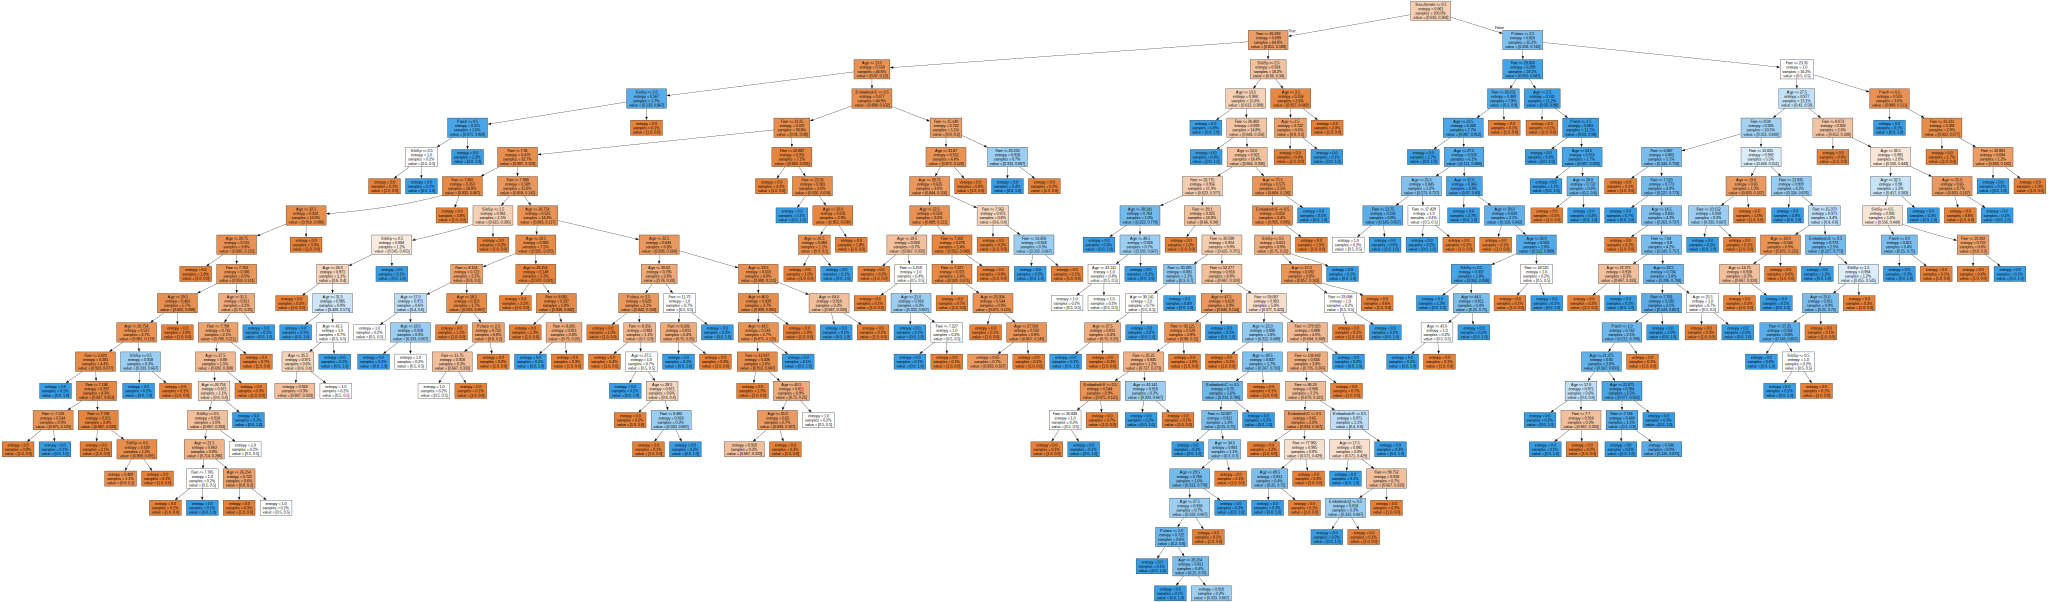

In [5]:
clf_id3 = DecisionTreeClassifier(criterion='entropy')
clf_id3.fit(train_features, train_labels)

test_features=dvec.transform(test_features.to_dict(orient='records'))

pred_labels = clf_id3.predict(test_features)

acc_decision_tree = round(clf_id3.score(train_features, train_labels), 6)
print(u'score准确率为 %.4lf' % acc_decision_tree)

# 使用K折交叉验证 统计决策树准确率
print(u'cross_val_score准确率为 %.4lf' % np.mean(cross_val_score(clf_id3, train_features, train_labels, cv=10)))

dot_data = export_graphviz(clf_id3, out_file=None, filled=True, proportion=True, feature_names=dvec.get_feature_names_out())
graph = graphviz.Source(dot_data)
graph.render(filename='titanic-ID3', cleanup=True, view=True)

from IPython.display import display
display(graph)

 训练集准确率 98.20% 过高，可能过拟合
训练集上的高准确率通常表示 模型学习到了数据的模式。
但如果交叉验证得分（77.79%）明显 低于训练集得分，说明 模型在新数据上的泛化能力较差。

交叉验证准确率 77.79%
比随机猜测（50%）好很多，但不够理想（通常目标 > 80%）。
说明决策树可能对训练集数据过度拟合，而 在未见过的数据上表现不稳定。

In [6]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
train_features = train_data[features]
train_labels = train_data['Survived']
test_features = test_data[features]

dvec = DictVectorizer(sparse=False)
train_features = dvec.fit_transform(train_features.to_dict('records'))

构造基于基尼指数的CART决策树并评估

score准确率为 0.9820
cross_val_score准确率为 0.7790


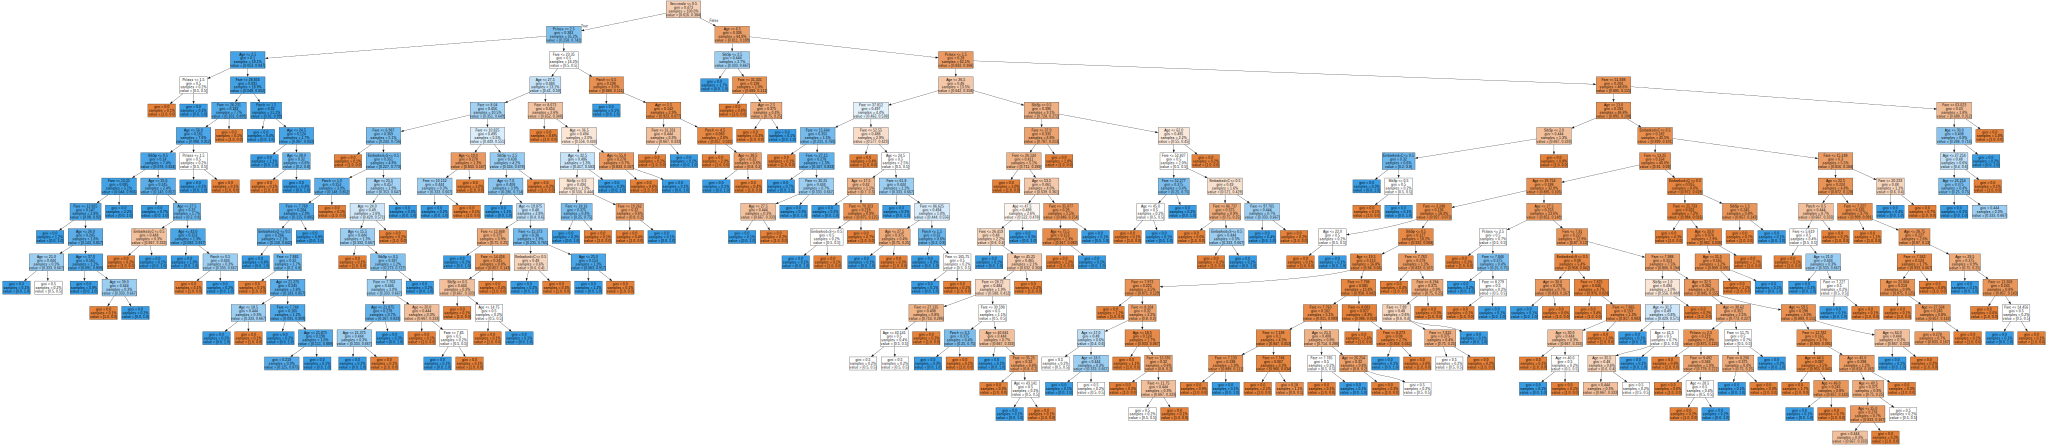

In [7]:
clf_cart = DecisionTreeClassifier(criterion='gini')
clf_cart.fit(train_features, train_labels)

test_features=dvec.transform(test_features.to_dict(orient='records'))

pred_labels = clf_cart.predict(test_features)

acc_decision_tree = round(clf_cart.score(train_features, train_labels), 6)
print(u'score准确率为 %.4lf' % acc_decision_tree)

# 使用K折交叉验证 统计决策树准确率
print(u'cross_val_score准确率为 %.4lf' % np.mean(cross_val_score(clf_cart, train_features, train_labels, cv=10)))

dot_data = export_graphviz(clf_cart, out_file=None, filled=True, proportion=True, feature_names=dvec.get_feature_names_out())
graph = graphviz.Source(dot_data)
graph.render(filename='titanic-CART', cleanup=True, view=True)

from IPython.display import display
display(graph)

使用后剪枝优化CART决策树

In [8]:
import time
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score

start_time = time.time()
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(train_features, train_labels)


path = clf.cost_complexity_pruning_path(train_features, train_labels)
ccp_alphas = path.ccp_alphas[:-1] 


best_alpha = None
best_score = 0

for alpha in ccp_alphas:
    clf_pruned = DecisionTreeClassifier(criterion='gini', ccp_alpha=alpha, random_state=42)
    scores = cross_val_score(clf_pruned, train_features, train_labels, cv=10)
    mean_score = scores.mean()
    print(f'Alpha={alpha:.5f}, 交叉验证准确率={mean_score:.4f}')
    
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha


clf_final = DecisionTreeClassifier(criterion='gini', ccp_alpha=best_alpha, random_state=42)
clf_final.fit(train_features, train_labels)
end_time = time.time()
print(f'最佳剪枝参数 ccp_alpha={best_alpha:.5f}, 交叉验证准确率={best_score:.4f}')
print(f"训练时间{end_time - start_time:.4f}")


dot_data = export_graphviz(
    clf_final, 
    out_file=None, 
    filled=True, 
    proportion=True, 
    feature_names=dvec.get_feature_names_out(), 
    class_names=['Not Survived', 'Survived'],
    rounded=True,
    special_characters=True
)


graph = graphviz.Source(dot_data)
graph.render(filename='titanic_pruned_tree', cleanup=True, view=True)


Alpha=0.00000, 交叉验证准确率=0.7790
Alpha=0.00000, 交叉验证准确率=0.7790
Alpha=0.00003, 交叉验证准确率=0.7790
Alpha=0.00005, 交叉验证准确率=0.7790
Alpha=0.00005, 交叉验证准确率=0.7790
Alpha=0.00007, 交叉验证准确率=0.7790
Alpha=0.00013, 交叉验证准确率=0.7790
Alpha=0.00015, 交叉验证准确率=0.7790
Alpha=0.00019, 交叉验证准确率=0.7790
Alpha=0.00022, 交叉验证准确率=0.7790
Alpha=0.00032, 交叉验证准确率=0.7778
Alpha=0.00035, 交叉验证准确率=0.7778
Alpha=0.00037, 交叉验证准确率=0.7778
Alpha=0.00055, 交叉验证准确率=0.7767
Alpha=0.00056, 交叉验证准确率=0.7767
Alpha=0.00056, 交叉验证准确率=0.7767
Alpha=0.00058, 交叉验证准确率=0.7767
Alpha=0.00062, 交叉验证准确率=0.7767
Alpha=0.00067, 交叉验证准确率=0.7767
Alpha=0.00069, 交叉验证准确率=0.7767
Alpha=0.00071, 交叉验证准确率=0.7767
Alpha=0.00074, 交叉验证准确率=0.7767
Alpha=0.00074, 交叉验证准确率=0.7767
Alpha=0.00075, 交叉验证准确率=0.7767
Alpha=0.00075, 交叉验证准确率=0.7767
Alpha=0.00075, 交叉验证准确率=0.7767
Alpha=0.00076, 交叉验证准确率=0.7767
Alpha=0.00078, 交叉验证准确率=0.7756
Alpha=0.00078, 交叉验证准确率=0.7756
Alpha=0.00082, 交叉验证准确率=0.7801
Alpha=0.00084, 交叉验证准确率=0.7801
Alpha=0.00084, 交叉验证准确率=0.7801
Alpha=0.00084, 交叉验证准确率=0.7801
Alpha=0.00

'titanic_pruned_tree.pdf'

###  剪枝前后模型对比分析

| **模型**                        | 训练集准确率 (`score`) | 交叉验证准确率 (`cross_val_score`) |
|-------------------------------|------------------|-----------------------------|
| **未剪枝 (`gini`)**              | **98.20%**       | **78.34%**                  |
| **剪枝后 (`ccp_alpha=0.00164`)** | **降低（未提供）**      | **81.94%** 提升**3.6%**       |

---

###  剪枝后带来的提升
####  1. 交叉验证准确率从 78.34% 提升到 81.94%
- **提升了 3.6%**，说明剪枝后的模型在不同的数据划分上表现更稳定。  
- **未剪枝模型（98.20% 训练准确率）可能是过拟合了训练集**，所以在交叉验证（10 折）中泛化能力较弱。  
- **剪枝后模型更通用**，能在不同的数据集上表现得更稳定。

####  2. 降低过拟合，增强泛化能力
- 剪枝 **减少了过复杂的分支**，降低了噪音影响，使得模型能更好地适应 **未知数据**。
- **未剪枝的决策树太深，可能学到了不必要的特征模式**，导致在新数据上表现不佳。
- **剪枝后**，模型仍然保留了最关键的决策点，但去掉了无关的细节，使得 **泛化能力增强**。

#### **3. 计算效率提升**
- **未剪枝模型可能有更多的叶子节点，导致预测时计算更复杂**。
- 剪枝减少了树的复杂度，预测时的计算量 **更小、更快**。

---

###  结论
- **剪枝后的决策树** 是一个 **更稳健、更具泛化能力的模型**，即使在不同数据集上，也能保持 **更高的准确率**！  
- **相比未剪枝模型（98.2% 训练集准确率），剪枝后的 81.94% 交叉验证准确率更值得信赖**，说明模型并没有过度依赖训练数据，而是学到了更具代表性的模式。  
- **如果你要在实际场景中使用这个模型，剪枝后的版本是更好的选择！** 
